In [199]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [200]:
pd.set_option('display.max_columns', 500)

In [201]:
from google.cloud import bigquery
from google.oauth2 import service_account

In [202]:
key_path = './service_account/gentle-keyword-423715-j0-03be08ad6412.json'

credentials = service_account.Credentials.from_service_account_file(
    key_path,
    scopes=["https://www.googleapis.com/auth/bigquery"]
)

In [203]:
from google.cloud import bigquery

client = bigquery.Client(
    credentials = credentials,
    project=credentials.project_id
)

In [204]:
query = """
SELECT
  u.id user_id,
  DATE(EXTRACT(YEAR FROM u.created_at), EXTRACT(MONTH FROM u.created_at), 1) created_account_date,
  u.age,
  o.order_id,
  o.num_of_item,
  DATE(EXTRACT(YEAR FROM o.created_at), EXTRACT(MONTH FROM o.created_at), 1) order_date,
  oi.sale_price * o.num_of_item revenue,
  e.session_id,
  e.id event_id,
  e.traffic_source traffic_session,
FROM `bigquery-public-data.thelook_ecommerce.users` u
LEFT JOIN `bigquery-public-data.thelook_ecommerce.order_items` oi
  ON oi.user_id = u.id
LEFT JOIN `bigquery-public-data.thelook_ecommerce.orders` o
  ON u.id = o.user_id AND oi.order_id = o.order_id
INNER JOIN `bigquery-public-data.thelook_ecommerce.products` p
  ON oi.product_id = p.id
LEFT JOIN `bigquery-public-data.thelook_ecommerce.events` e
  ON u.id = e.id
WHERE 
  o.status = 'Complete'
  AND
  (EXTRACT(YEAR FROM o.created_at) >= 2023)
"""

df = client.query(query).to_dataframe()
print(df.info())
df.head()

C:\Users\Baha Tegar\anaconda3\Lib\site-packages\google\cloud\bigquery\table.py:1727: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28341 entries, 0 to 28340
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   user_id               28341 non-null  Int64  
 1   created_account_date  28341 non-null  dbdate 
 2   age                   28341 non-null  Int64  
 3   order_id              28341 non-null  Int64  
 4   num_of_item           28341 non-null  Int64  
 5   order_date            28341 non-null  dbdate 
 6   revenue               28341 non-null  float64
 7   session_id            28341 non-null  object 
 8   event_id              28341 non-null  Int64  
 9   traffic_session       28341 non-null  object 
dtypes: Int64(5), dbdate(2), float64(1), object(2)
memory usage: 2.3+ MB
None


,user_id,created_account_date,age,order_id,num_of_item,order_date,revenue,session_id,event_id,traffic_session
0,99565,2022-08-01,23,124285,2,2024-05-01,29.980000,6b8471a1-0f25-46fe-826a-15f0097e87cb,99565,Facebook
1,70019,2022-08-01,57,87448,2,2024-03-01,30.000000,a661cf59-bcc6-4c45-85a5-aeeb8e2c23fd,70019,Adwords
2,49677,2022-08-01,24,61948,1,2023-03-01,16.080000,a8c9ac68-7e4f-4216-8c2b-14c59921347c,49677,Facebook
3,99565,2022-08-01,23,124285,2,2024-05-01,33.980000,6b8471a1-0f25-46fe-826a-15f0097e87cb,99565,Facebook
4,85436,2022-08-01,41,106610,1,2024-03-01,27.299999,88a9253b-9836-4502-80e0-d0385d863dbd,85436,Email


In [205]:
df['order_id'] = df['order_id'].astype(str)
df['user_id'] = df['user_id'].astype(str)
df['order_date'] = pd.to_datetime(df['order_date'])
df['created_account_date'] = pd.to_datetime(df['created_account_date'])

print("Number of unique user_id: ", df['user_id'].nunique())

print(df.info())

Number of unique user_id:  17698
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28341 entries, 0 to 28340
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   user_id               28341 non-null  object        
 1   created_account_date  28341 non-null  datetime64[ns]
 2   age                   28341 non-null  Int64         
 3   order_id              28341 non-null  object        
 4   num_of_item           28341 non-null  Int64         
 5   order_date            28341 non-null  datetime64[ns]
 6   revenue               28341 non-null  float64       
 7   session_id            28341 non-null  object        
 8   event_id              28341 non-null  Int64         
 9   traffic_session       28341 non-null  object        
dtypes: Int64(3), datetime64[ns](2), float64(1), object(4)
memory usage: 2.2+ MB
None


In [206]:
from sklearn.preprocessing import StandardScaler

# Aggregating
# map_agg = {
#     'traffic_source': pd.Series.mode,
#     'created_account_date': 'min',
#     'order_id': 'nunique',
#     'num_of_item': 'sum',
#     'order_date': 'max',
#     'revenue': 'sum',
#     'session_id': 'count'
# }
map_agg = {
    'traffic_session': pd.Series.mode,
    'event_id': 'count',
    'created_account_date': 'min',
    'order_id': 'nunique',
    'num_of_item': 'sum',
    'order_date': 'max',
    'revenue': 'sum',
    'session_id': 'count'
}

df_grouped = df.groupby('user_id')\
                .agg(map_agg)\
                .reset_index()

# new_columns = []
# for c in df_grouped.columns:
#     if (c[-1] == '') or (c[-1] in ['first', 'max', 'min', 'nunique', 'mode']):
#         new_columns.append(c[0])
#         continue
#     new_columns.append(c[0] + '_' + c[1])

# df_grouped.columns = new_columns

# Feature Engineering
currentDate = df['order_date'].max()
df_grouped['recency'] = round((currentDate - df_grouped['order_date']) / pd.to_timedelta(1, 'day'))
# df_grouped['age_account'] = round((currentDate - df_grouped['created_account_date']) / pd.to_timedelta(1, 'day'))
# df_grouped['diff_last_order_to_create'] = round((df_grouped['order_date'] - df_grouped['created_account_date']) / pd.to_timedelta(1, 'day'))

df_grouped = df_grouped.drop(['order_date', 'created_account_date'], axis=1)\
                        .rename(columns={'num_of_item': 'total_item',
                                        'order_id': 'total_order',
                                        'session_id': 'total_session',
                                        'event_id': 'total_click'})

# df_grouped = df_grouped[df_grouped['recency'] < 180]
print(df_grouped.info())
df_grouped.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17698 entries, 0 to 17697
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   user_id          17698 non-null  object 
 1   traffic_session  17698 non-null  object 
 2   total_click      17698 non-null  int64  
 3   total_order      17698 non-null  int64  
 4   total_item       17698 non-null  Int64  
 5   revenue          17698 non-null  float64
 6   total_session    17698 non-null  int64  
 7   recency          17698 non-null  float64
dtypes: Int64(1), float64(2), int64(3), object(2)
memory usage: 1.1+ MB
None


,user_id,traffic_session,total_click,total_order,total_item,revenue,total_session,recency
0,1,Adwords,1,1,1,83.360001,1,152.0
1,10000,Email,1,1,1,31.990000,1,31.0
2,100000,Email,3,2,5,245.480003,3,336.0
3,10004,Email,4,1,16,1224.040001,4,152.0
4,1001,Adwords,1,1,1,46.000000,1,244.0


In [207]:
df_grouped.describe()

,total_click,total_order,total_item,revenue,total_session,recency
count,17698.000000,17698.000000,17698.0,17698.000000,17698.000000,17698.000000
mean,1.601367,1.098881,3.050345,182.965206,1.601367,197.204486
std,0.972721,0.325670,3.9243,304.483909,0.972721,153.864994
min,1.000000,1.000000,1.0,0.020000,1.000000,0.000000
25%,1.000000,1.000000,1.0,32.950001,1.000000,61.000000
50%,1.000000,1.000000,1.0,69.989998,1.000000,152.000000
75%,2.000000,1.000000,4.0,189.899998,2.000000,305.000000
max,8.000000,4.000000,32.0,5615.759995,8.000000,517.000000


In [208]:
# low_variance = ['total_item', 'total_order']

# Copy dataframe
df_enc_scaled = df_grouped.copy()

# # Bin age
# df_enc_scaled['age'] = pd.qcut(df_grouped['age'], q=3, labels=['Teen', 'Adult', 'Old'])

# Encoding
encoded_columns = ['traffic_session']
enc_result_columns = []
for c in encoded_columns:
    temp = pd.get_dummies(df_enc_scaled[c], prefix=c).astype(int)
    enc_result_columns = enc_result_columns + list(temp.columns)
    df_enc_scaled = pd.concat([df_enc_scaled, temp], axis=1)

df_enc_scaled = df_enc_scaled.drop(encoded_columns, axis=1)
# df_enc_scaled = df_enc_scaled.drop(encoded_columns + low_variance, axis=1).rename(columns=map_rename)
# df_enc_scaled = df_enc_scaled.drop(encoded_columns, axis=1).rename(columns=map_rename)

# StandardScaler numeric data
sc = StandardScaler()
# sc_columns = ['revenue', 'recency', 'age_account', 'diff_last_order_to_create', ]
sc_columns = ['revenue', 'recency',]

df_enc_scaled[sc_columns] = sc.fit_transform(df_enc_scaled[sc_columns])

print(df_enc_scaled.info())
df_enc_scaled.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17698 entries, 0 to 17697
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   user_id                   17698 non-null  object 
 1   total_click               17698 non-null  int64  
 2   total_order               17698 non-null  int64  
 3   total_item                17698 non-null  Int64  
 4   revenue                   17698 non-null  float64
 5   total_session             17698 non-null  int64  
 6   recency                   17698 non-null  float64
 7   traffic_session_Adwords   17698 non-null  int32  
 8   traffic_session_Email     17698 non-null  int32  
 9   traffic_session_Facebook  17698 non-null  int32  
 10  traffic_session_Organic   17698 non-null  int32  
 11  traffic_session_YouTube   17698 non-null  int32  
dtypes: Int64(1), float64(2), int32(5), int64(3), object(1)
memory usage: 1.3+ MB
None


,user_id,total_click,total_order,total_item,revenue,total_session,recency,traffic_session_Adwords,traffic_session_Email,traffic_session_Facebook,traffic_session_Organic,traffic_session_YouTube
0,1,1,1,1,-0.327137,1,-0.293801,1,0,0,0,0
1,10000,1,1,1,-0.495854,1,-1.080227,0,1,0,0,0
2,100000,3,2,5,0.205320,3,0.902086,0,1,0,0,0
3,10004,4,1,16,3.419242,4,-0.293801,0,1,0,0,0
4,1001,1,1,1,-0.449840,1,0.304142,1,0,0,0,0


**KMeans**

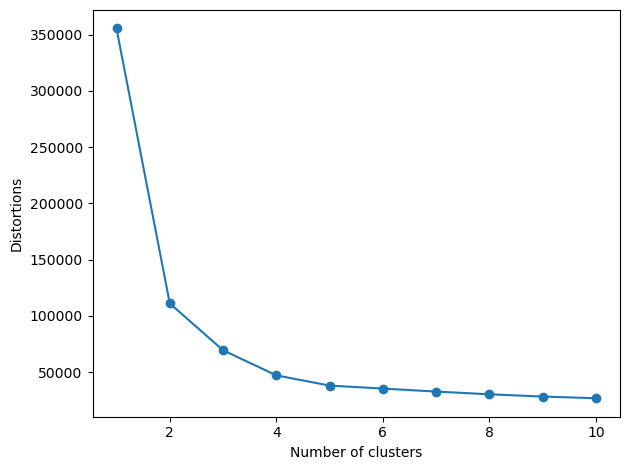

In [209]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

X = df_enc_scaled.drop('user_id', axis=1)
distortions = []
for i in range(1, 11):
    km = KMeans(n_clusters=i,
                init='k-means++',
                n_init=10,
                max_iter=300,
                random_state=0)
    
    km.fit(X)
    distortions.append(km.inertia_)
    
plt.plot(range(1, 11), distortions, marker='o')
plt.xlabel("Number of clusters")
plt.ylabel("Distortions")
plt.tight_layout()
plt.show()

0.5483079020133077


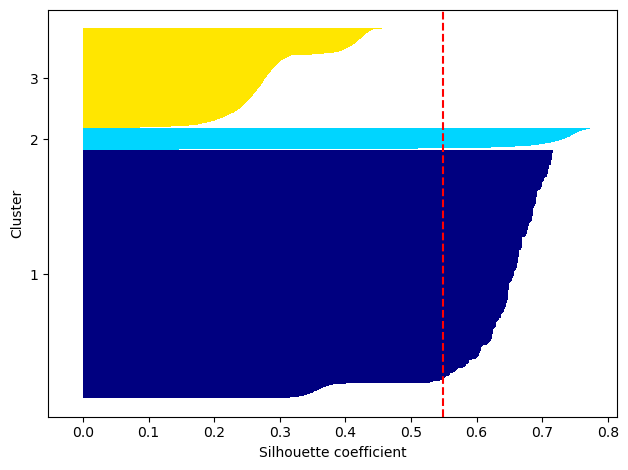

In [210]:
from sklearn.metrics import silhouette_samples
from matplotlib import cm

km = KMeans(n_clusters=3,
            init='k-means++',
            n_init=10,
            max_iter=300,
            tol=1e-04,
            random_state=0)

y_km = km.fit_predict(X)

cluster_labels = np.unique(y_km)
n_clusters = cluster_labels.shape[0]
silhouette_vals = silhouette_samples(X, y_km, metric='euclidean')
y_ax_lower, y_ax_upper = 0, 0
yticks = []
for i, c in enumerate(cluster_labels):
    c_silhouette_vals = silhouette_vals[y_km == c]
    c_silhouette_vals.sort()
    y_ax_upper += len(c_silhouette_vals)
    color = cm.jet(float(i) / n_clusters)
    plt.barh(range(y_ax_lower, y_ax_upper),
             c_silhouette_vals,
             height=1.0,
             edgecolor='none',
             color=color)
    yticks.append((y_ax_lower + y_ax_upper) / 2.)
    y_ax_lower += len(c_silhouette_vals)

silhouette_avg = np.mean(silhouette_vals)
print(silhouette_avg)
plt.axvline(silhouette_avg,
            color='red',
            linestyle='--')
plt.yticks(yticks, cluster_labels + 1)
plt.ylabel("Cluster")
plt.xlabel("Silhouette coefficient")
plt.tight_layout()
plt.show()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17698 entries, 0 to 17697
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   user_id          17698 non-null  object 
 1   traffic_session  17698 non-null  object 
 2   total_click      17698 non-null  int64  
 3   total_order      17698 non-null  int64  
 4   total_item       17698 non-null  Int64  
 5   revenue          17698 non-null  float64
 6   total_session    17698 non-null  int64  
 7   recency          17698 non-null  float64
dtypes: Int64(1), float64(2), int64(3), object(2)
memory usage: 1.1+ MB
None


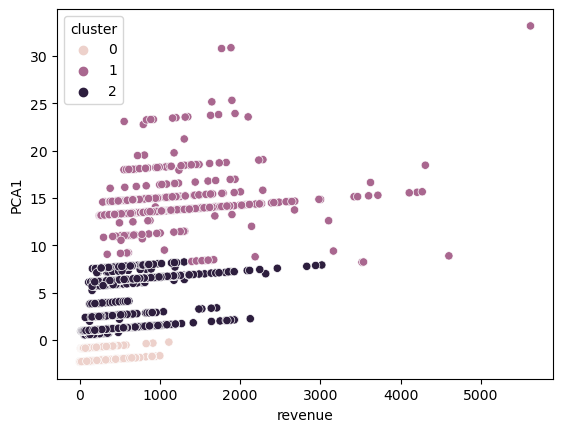

In [211]:
import seaborn as sns
from sklearn.decomposition import PCA

km = KMeans(n_clusters=3,
            init='k-means++',
            n_init=10,
            max_iter=300,
            random_state=0).fit(X)


labels = list(km.labels_)

result = df_grouped.copy()

result['cluster'] = labels

print(df_grouped.info())

# Decompose fields
pca = PCA(n_components=2)

transform = pca.fit_transform(df_enc_scaled.drop('user_id', axis=1).values)

result[['PCA1', 'PCA2']] = transform

sns.scatterplot(data=result, y= 'PCA1', x='revenue', hue='cluster',)
plt.show()

In [212]:
pivot_table = result.pivot_table(
    values=['recency', 'revenue','total_order', 'total_item', 'total_session', 'total_click'],
    index='cluster',
    aggfunc=['mean', 'max', 'min', 'median']
)

pivot_table

mean                                                 \
            recency     revenue total_click total_item total_order   
cluster                                                              
0        200.764360   62.816969    1.058616   1.058616    1.058616   
1        181.752178  992.883302    4.328170  16.242982    1.270087   
2        191.681190  306.978046    2.363217   5.156682    1.162128   

                          max                                                  \
        total_session recency      revenue total_click total_item total_order   
cluster                                                                         
0            1.058616   517.0  1112.000000           2          2           2   
1            4.328170   517.0  5615.759995           8         32           4   
2            2.363217   517.0  3016.799995           5         10           4   

                          min                                                 \
        total_session recency     revenue total_click total_item total_order   
cluster                                                                        
0                   2     0.0    0.020000           1          1           1   
1                   8     0.0  243.760002           3          9           1   
2                   5     0.0   17.900000           2          3           1   

                       median                                                 \
        total_session recency     revenue total_click total_item total_order   
cluster                                                                        
0                   1   183.0   42.950001           1        1.0           1   
1                   3   152.0  844.480000           4       16.0           1   
2                   2   152.0  231.924997           2        4.0           1   

                       
        total_session  
cluster                
0                   1  
1                   4  
2                   2

**Hierarchical**

0.5483079020133077


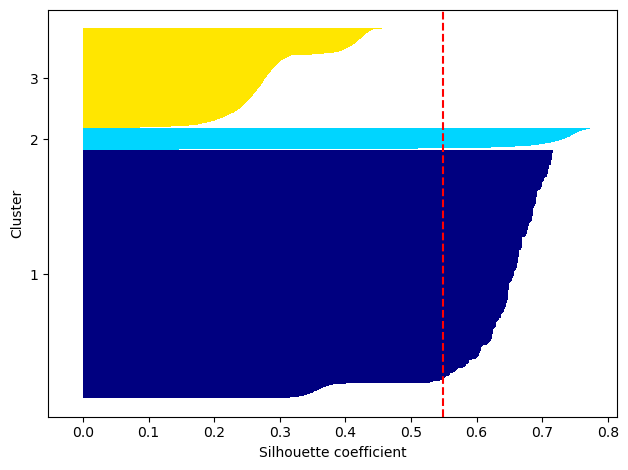

In [213]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import AgglomerativeClustering

agg = AgglomerativeClustering(n_clusters=3, metric='euclidean', linkage='ward')

y_agg = km.fit_predict(X)

cluster_labels = np.unique(y_agg)
n_clusters = cluster_labels.shape[0]
silhouette_vals = silhouette_samples(X, y_agg, metric='euclidean')
y_ax_lower, y_ax_upper = 0, 0
yticks = []
for i, c in enumerate(cluster_labels):
    c_silhouette_vals = silhouette_vals[y_agg == c]
    c_silhouette_vals.sort()
    y_ax_upper += len(c_silhouette_vals)
    color = cm.jet(float(i) / n_clusters)
    plt.barh(range(y_ax_lower, y_ax_upper),
             c_silhouette_vals,
             height=1.0,
             edgecolor='none',
             color=color)
    yticks.append((y_ax_lower + y_ax_upper) / 2.)
    y_ax_lower += len(c_silhouette_vals)

silhouette_avg = np.mean(silhouette_vals)
print(silhouette_avg)
plt.axvline(silhouette_avg,
            color='red',
            linestyle='--')
plt.yticks(yticks, cluster_labels + 1)
plt.ylabel("Cluster")
plt.xlabel("Silhouette coefficient")
plt.tight_layout()
plt.show()

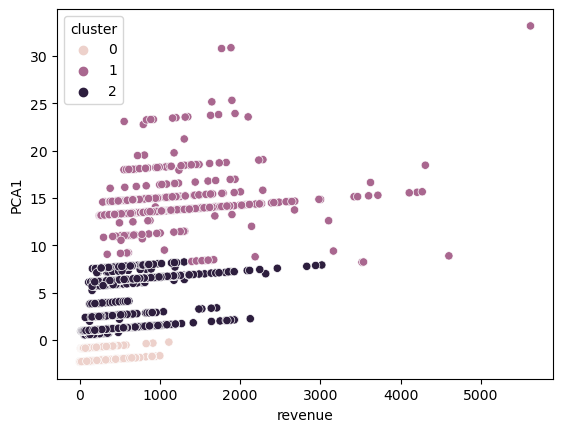

In [214]:
import seaborn as sns
from sklearn.decomposition import PCA

labels = list(y_km)

result = df_grouped.copy()

result['cluster'] = labels

# Decompose fields
pca = PCA(n_components=2)

transform = pca.fit_transform(df_enc_scaled.drop('user_id', axis=1).values)

result[['PCA1', 'PCA2']] = transform

sns.scatterplot(data=result, y= 'PCA1', x='revenue', hue='cluster',)
plt.show()

In [215]:
pivot_table = result.pivot_table(
    values=['recency', 'revenue','total_order', 'total_item', 'total_session', 'total_click'],
    index='cluster',
    aggfunc=['mean', 'max', 'min', 'median']
)

pivot_table

mean                                                 \
            recency     revenue total_click total_item total_order   
cluster                                                              
0        200.764360   62.816969    1.058616   1.058616    1.058616   
1        181.752178  992.883302    4.328170  16.242982    1.270087   
2        191.681190  306.978046    2.363217   5.156682    1.162128   

                          max                                                  \
        total_session recency      revenue total_click total_item total_order   
cluster                                                                         
0            1.058616   517.0  1112.000000           2          2           2   
1            4.328170   517.0  5615.759995           8         32           4   
2            2.363217   517.0  3016.799995           5         10           4   

                          min                                                 \
        total_session recency     revenue total_click total_item total_order   
cluster                                                                        
0                   2     0.0    0.020000           1          1           1   
1                   8     0.0  243.760002           3          9           1   
2                   5     0.0   17.900000           2          3           1   

                       median                                                 \
        total_session recency     revenue total_click total_item total_order   
cluster                                                                        
0                   1   183.0   42.950001           1        1.0           1   
1                   3   152.0  844.480000           4       16.0           1   
2                   2   152.0  231.924997           2        4.0           1   

                       
        total_session  
cluster                
0                   1  
1                   4  
2                   2

**DBSCAN**

In [216]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=0.3, min_samples=5)
clusters = dbscan.fit_predict(X)

if len(set(clusters)) > 1:
    silhouette_avg = silhouette_score(X, clusters)
    print(f"Silhouette Score: {silhouette_avg}")
else:
    print("Silhouette Score cannot be calculated for a single cluster")

Silhouette Score: 0.264506077890779


0.264506077890779


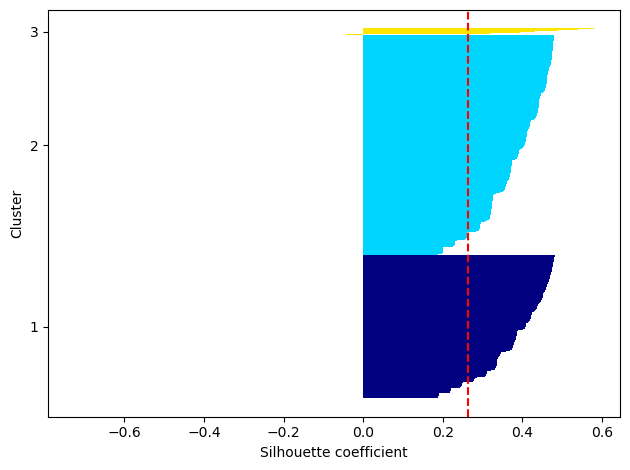

In [217]:
dbscan = DBSCAN(eps=0.3, min_samples=5)

y_dbscan = dbscan.fit_predict(X)

cluster_labels = np.unique(y_km)
n_clusters = cluster_labels.shape[0]
silhouette_vals = silhouette_samples(X, y_dbscan, metric='euclidean')
y_ax_lower, y_ax_upper = 0, 0
yticks = []
for i, c in enumerate(cluster_labels):
    c_silhouette_vals = silhouette_vals[y_dbscan == c]
    c_silhouette_vals.sort()
    y_ax_upper += len(c_silhouette_vals)
    color = cm.jet(float(i) / n_clusters)
    plt.barh(range(y_ax_lower, y_ax_upper),
             c_silhouette_vals,
             height=1.0,
             edgecolor='none',
             color=color)
    yticks.append((y_ax_lower + y_ax_upper) / 2.)
    y_ax_lower += len(c_silhouette_vals)

silhouette_avg = np.mean(silhouette_vals)
print(silhouette_avg)
plt.axvline(silhouette_avg,
            color='red',
            linestyle='--')
plt.yticks(yticks, cluster_labels + 1)
plt.ylabel("Cluster")
plt.xlabel("Silhouette coefficient")
plt.tight_layout()
plt.show()

**Kernel Kmeans**

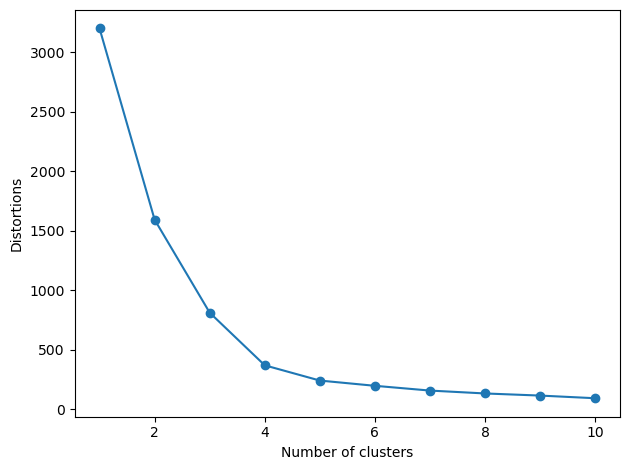

In [222]:
from sklearn.decomposition import KernelPCA

# Kernel K-Means

# Apply Kernel PCA with RBF kernel
kpca = KernelPCA(n_components=2, kernel='rbf', gamma=1.0)

X_kpca = kpca.fit_transform(X)

distortions = []
for i in range(1, 11):
    km = KMeans(n_clusters=i,
                init='k-means++',
                n_init=10,
                max_iter=300,
                random_state=0)
    
    km.fit(X_kpca)
    distortions.append(km.inertia_)
    
plt.plot(range(1, 11), distortions, marker='o')
plt.xlabel("Number of clusters")
plt.ylabel("Distortions")
plt.tight_layout()
plt.show()

0.6813482175758151


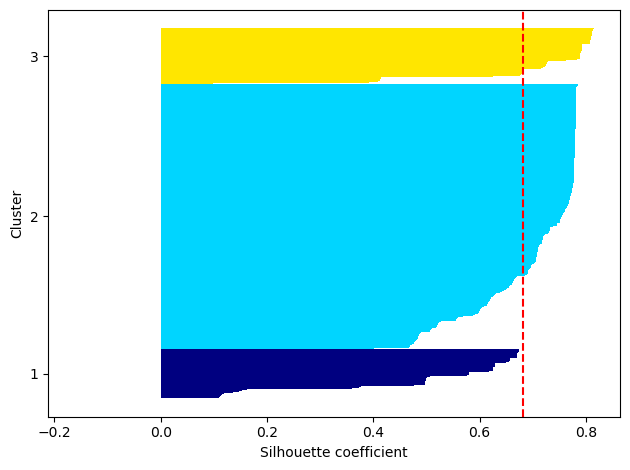

In [223]:
km = KMeans(n_clusters=3,
            init='k-means++',
            n_init=10,
            max_iter=300,
            tol=1e-04,
            random_state=0)

y_km = km.fit_predict(X_kpca)

cluster_labels = np.unique(y_km)
n_clusters = cluster_labels.shape[0]
silhouette_vals = silhouette_samples(X_kpca, y_km, metric='euclidean')
y_ax_lower, y_ax_upper = 0, 0
yticks = []
for i, c in enumerate(cluster_labels):
    c_silhouette_vals = silhouette_vals[y_km == c]
    c_silhouette_vals.sort()
    y_ax_upper += len(c_silhouette_vals)
    color = cm.jet(float(i) / n_clusters)
    plt.barh(range(y_ax_lower, y_ax_upper),
             c_silhouette_vals,
             height=1.0,
             edgecolor='none',
             color=color)
    yticks.append((y_ax_lower + y_ax_upper) / 2.)
    y_ax_lower += len(c_silhouette_vals)

silhouette_avg = np.mean(silhouette_vals)
print(silhouette_avg)
plt.axvline(silhouette_avg,
            color='red',
            linestyle='--')
plt.yticks(yticks, cluster_labels + 1)
plt.ylabel("Cluster")
plt.xlabel("Silhouette coefficient")
plt.tight_layout()
plt.show()

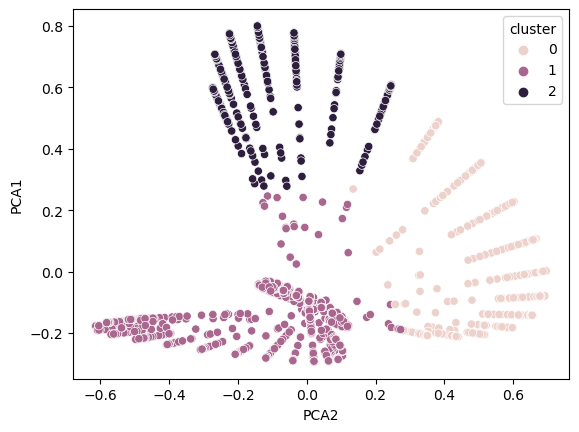

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17698 entries, 0 to 17697
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   user_id          17698 non-null  object 
 1   traffic_session  17698 non-null  object 
 2   total_click      17698 non-null  int64  
 3   total_order      17698 non-null  int64  
 4   total_item       17698 non-null  Int64  
 5   revenue          17698 non-null  float64
 6   total_session    17698 non-null  int64  
 7   recency          17698 non-null  float64
 8   cluster          17698 non-null  int32  
 9   PCA1             17698 non-null  float64
 10  PCA2             17698 non-null  float64
dtypes: Int64(1), float64(4), int32(1), int64(3), object(2)
memory usage: 1.4+ MB
None


,user_id,traffic_session,total_click,total_order,total_item,revenue,total_session,recency,cluster,PCA1,PCA2
0,1,Adwords,1,1,1,83.360001,1,152.0,1,-0.219769,-0.493446
1,10000,Email,1,1,1,31.990000,1,31.0,2,0.703975,-0.265920
2,100000,Email,3,2,5,245.480003,3,336.0,1,-0.123640,0.007406
3,10004,Email,4,1,16,1224.040001,4,152.0,1,-0.124309,0.007448
4,1001,Adwords,1,1,1,46.000000,1,244.0,1,-0.268978,-0.208343


In [224]:
result = df_grouped.copy()
result['cluster'] = y_km

result[['PCA1', 'PCA2']] = X_kpca
# df_grouped[['PCA1', 'PCA2', 'PCA3']] = X_kpca
# df_grouped[['PCA1', 'PCA2', 'PCA3', 'PCA4']] = X_kpca

sns.scatterplot(data=result, y= 'PCA1', x='PCA2', hue='cluster',)
plt.show()


print(result.info())
result.head()

In [225]:
pivot_table = result.pivot_table(
    values=['recency', 'revenue','total_order', 'total_item', 'total_session', 'total_click'],
    index='cluster',
    aggfunc=['mean', 'max', 'min', 'median']
)

pivot_table

mean                                                 \
            recency     revenue total_click total_item total_order   
cluster                                                              
0        349.186706   56.453078    1.000000        1.0    1.000000   
1        193.101197  232.627265    1.838163   3.857694    1.137817   
2         80.874526   57.192964    1.000000        1.0    1.000000   

                          max                                                  \
        total_session recency      revenue total_click total_item total_order   
cluster                                                                         
0            1.000000   517.0   374.500000           1          1           1   
1            1.838163   517.0  5615.759995           8         32           4   
2            1.000000   183.0   338.000000           1          1           1   

                          min                                             \
        total_session recency revenue total_click total_item total_order   
cluster                                                                    
0                   1   183.0    0.02           1          1           1   
1                   8     0.0    1.51           1          1           1   
2                   1     0.0    2.95           1          1           1   

                       median                                                 \
        total_session recency     revenue total_click total_item total_order   
cluster                                                                        
0                   1   336.0   39.990002           1        1.0           1   
1                   1   152.0  105.320003           2        2.0           1   
2                   1    61.0   41.530001           1        1.0           1   

                       
        total_session  
cluster                
0                   1  
1                   2  
2                   1

In [ ]:
result.to_csv('')